In [1]:
from pathlib import Path
import datetime
import xarray as xr
import json
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])


# Paths
basepath = Path("/workspace/data/s3/earthnet/earthnet2023/")
train_paths = list(basepath.glob("train/*/*.nc"))
test_paths = list(basepath.glob("test/*/*.nc"))
pred_paths = list(Path("/workspace/crobin/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_anomalie/preds/iid/").glob("*/*"))


**Missing data analysis**   
1- Plot in time for missing data for 1 minicube

/workspace/data/s3/earthnet/earthnet2023/train/Algeria/31SGU1543.nc


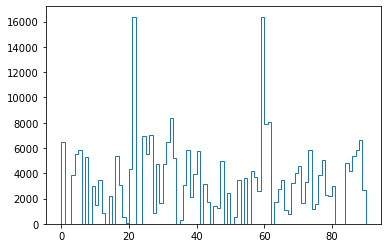

In [14]:
#file = train_paths[109]
file = Path("/workspace/data/s3/earthnet/earthnet2023/train/Algeria/31SGU1543.nc")
print(file)
minicube = xr.open_dataset(file).load()
# Subset of period with the 2 satellite and only 5 days gap
# minicube = minicube.where(minicube.time.dt.date
# > datetime.date(2017, 6, 30), drop=True) 

# Subset of every 5 days
indexes_avail = np.where(minicube.s2_avail.values == 1)[0]

time = [minicube.time.values[i] for i in range(indexes_avail[0], indexes_avail[-1] + 1, 5)]
dates = [minicube.time.values[i] for i in (indexes_avail)]
# Condition to check that the every 5 days inclus all the dates available (+ missing day)
if set(dates) <= set(time):
    mask = minicube.s2_mask.sel(time=time)
else: 
    print("ERROR")

# Transform 
mask.values[mask.values > 1] = np.nan

# Computation of the NaN values
series_nan  = np.sum(np.isnan(mask), axis=(1,2))
plt.stairs(series_nan)
plt.show()

2- Plot the histogram of missing data in the train dataset

In [8]:
file = open("missing_value_train_from2016.json")
data = json.load(file)


In [9]:
total = np.array([d['total_missing'] for d in data.values()]) / (128 * 128)
series = [d['serie_missing'] for d in data.values()]
len_series = np.array([len(d['serie_missing']) for d in data.values()])

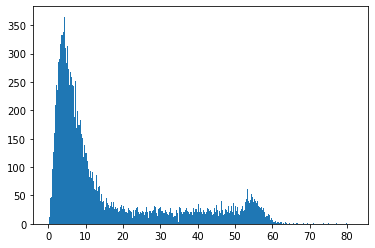

In [10]:
plt.hist(total * 100 / len_series, bins= 1000)
plt.show()

In [50]:
total = np.array([data[file]['total_missing'] for file in data.keys()])

In [25]:
from pathlib import Path
import datetime
import xarray as xr
import numpy as np
from tqdm import tqdm
import json
import random
import os

# Paths
#basepath = Path("/scratch/crobin/earthnet2023/")
basepath = Path("/workspace/data/s3/earthnet/earthnet2023/test/")
dst_path = "/scratch/crobin/earthnet2023_preprocessed/test/"


paths = list(basepath.glob("*/*.nc"))
print("len of the dataset: ", len(paths))

data = {}

for i, file in enumerate(tqdm(paths[1:5])):
    print(file)
    minicube = xr.open_dataset(file).load()
    # Subset of period with the 2 satellite and only 5 days gap
    minicube = minicube.where(
        minicube.time.dt.date > datetime.date(2017, 6, 30), drop=True
    )

    if len(minicube.time.dt.date.values) > 0:
        # Subset of every 5 days
        indexes_avail = np.where(minicube.s2_avail.values == 1)[0]
        if len(indexes_avail) > 0:
            beg = random.choice(indexes_avail[1:-90])
            name = str(file)[-12:]
            minicube.isel(time=slice(beg - 5, beg + 450)).to_netcdf(os.path.join(dst_path, str(file)[len(str(basepath)):]))
            # time = [
            #     minicube.time.values[i]
            #     for i in range(indexes_avail[0], indexes_avail[-1] + 1, 5)
            # ]
            # dates = [minicube.time.values[i] for i in (indexes_avail)]
            # # Condition to check that the every 5 days inclus all the dates available (+ missing day)
            # if set(dates) <= set(time):
            #     mask = minicube.s2_mask.sel(time=time)
            # else:
            #     print("ERROR: ", file)
            # # Transform
            # mask.values[mask.values > 1] = np.nan
            # # Computation of the NaN values
            # s = np.sum(np.isnan(mask), axis=(0, 1, 2)).values.tolist()
            # serie_nan = np.sum(np.isnan(mask), axis=(1, 2)).values.tolist()
            # data[str(file)] = {"total_missing": s, "serie_missing": serie_nan}

with open("missing_value_test_from2016.json", "w") as fp:
    json.dump(data, fp)


len of the dataset:  4534


  0%|          | 0/4 [00:00<?, ?it/s]

/workspace/data/s3/earthnet/earthnet2023/test/Angola/33LXE7425.nc


  0%|          | 0/4 [00:09<?, ?it/s]


PermissionError: [Errno 13] Permission denied: b'/Angola/33LXE7425.nc'